In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
# create engine to hawaii.sqlite
kaggle_engine = create_engine("sqlite:///../resources/cis_2018.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(kaggle_engine, reflect = True)

In [4]:
# View all of the classes that automap found
Base.classes.keys()

['sales']

In [5]:
# Save references to each table
kaggle_data = Base.classes
# Station = Base.classes.station

In [6]:
session = Session(kaggle_engine)

In [50]:
kaggle_list = session.query(kaggle_data.sales).all()
kaggle_list

In [37]:
kaggle_data.sales

sqlalchemy.ext.automap.sales

In [53]:
kaggle_list = kaggle_engine.execute("SELECT * FROM sales").fetchall()


In [54]:
kaggle_dict = {}
for (key, value) in kaggle_list:
    if key in kaggle_dict:
        kaggle_dict[key].append(value)
    else:
        kaggle_dict[key] = [value]
kaggle_dict

ValueError: too many values to unpack (expected 2)

# Exploratory Precipitation Analysis

In [11]:
# Measurement columns
inspector = inspect(engine)
columns = inspector.get_columns('sales')
for c in columns:
    print(f"{c['name']:<35} {c['type']}")

id                                  BIGINT
model_year                          FLOAT
make                                TEXT
model                               TEXT
msrp                                BIGINT
vehicle_type                        TEXT
milage                              BIGINT
axles                               FLOAT
base_price                          FLOAT
bed_length_inches                   FLOAT
bed_type                            TEXT
body_cab_type                       TEXT
body_class                          TEXT
doors                               FLOAT
drive_type                          TEXT
engine_hp                           FLOAT
top_speed_mph                       FLOAT
transmission_speeds                 FLOAT
transmission_style                  TEXT
cruise_control                      TEXT
auto_reverse_system                 TEXT
pedestrian_alerting_sound           TEXT
blind_spot_monitor                  TEXT
forward_collision_warning           TEXT
ke

In [10]:
# Station columns
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(f"{c['name']:<20} {c['type']}")

id                   INTEGER
station              TEXT
name                 TEXT
latitude             FLOAT
longitude            FLOAT
elevation            FLOAT


In [11]:
# Find the most recent date in the data set.
sel = [Measurement.date]
newest_date = session.query(*sel).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent record was recorded on: {newest_date}.")

The most recent record was recorded on: 2017-08-23.


In [12]:
# split string to break out year, mo, day
nd = newest_date.split('-')
nd
# cast strings as int
for i in range(len(nd)):
    nd[i] = int(nd[i])
nd
# store as datetime object
nd_dt = dt.date(nd[0], nd[1], nd[2])
nd_dt

datetime.date(2017, 8, 23)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
one_year_previous = nd_dt - dt.timedelta(days=365)
one_year_previous

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date <= newest_date).filter(Measurement.date >= one_year_previous).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year, columns=['station','date','prcp','tobs'])
last_year_df['date'] = pd.to_datetime(last_year_df['date'], format='%Y-%m-%d')
last_year_df = last_year_df.set_index('date')

# Sort the dataframe by date
last_year_df.sort_values(by=['date'], inplace=True)
last_year_df.head()

,station,prcp,tobs
date,,,
2016-08-23,USC00519397,0.00,81.0
2016-08-23,USC00517948,NaN,80.0
2016-08-23,USC00519281,1.79,77.0
2016-08-23,USC00514830,0.05,80.0
2016-08-23,USC00513117,0.15,76.0


In [14]:
no_index = last_year_df.reset_index()
precip_group = no_index.groupby('date')
precip_sum_df = precip_group.sum()
precip_sum_df_no_index = precip_sum_df.reset_index()
precip_sum_df_no_index

,date,prcp,tobs
0,2016-08-23,2.71,548.0
1,2016-08-24,9.33,543.0
2,2016-08-25,0.54,556.0
3,2016-08-26,0.10,483.0
4,2016-08-27,0.32,461.0
...,...,...,...
361,2017-08-19,0.09,315.0
362,2017-08-20,0.01,239.0
363,2017-08-21,0.58,318.0
364,2017-08-22,0.50,240.0


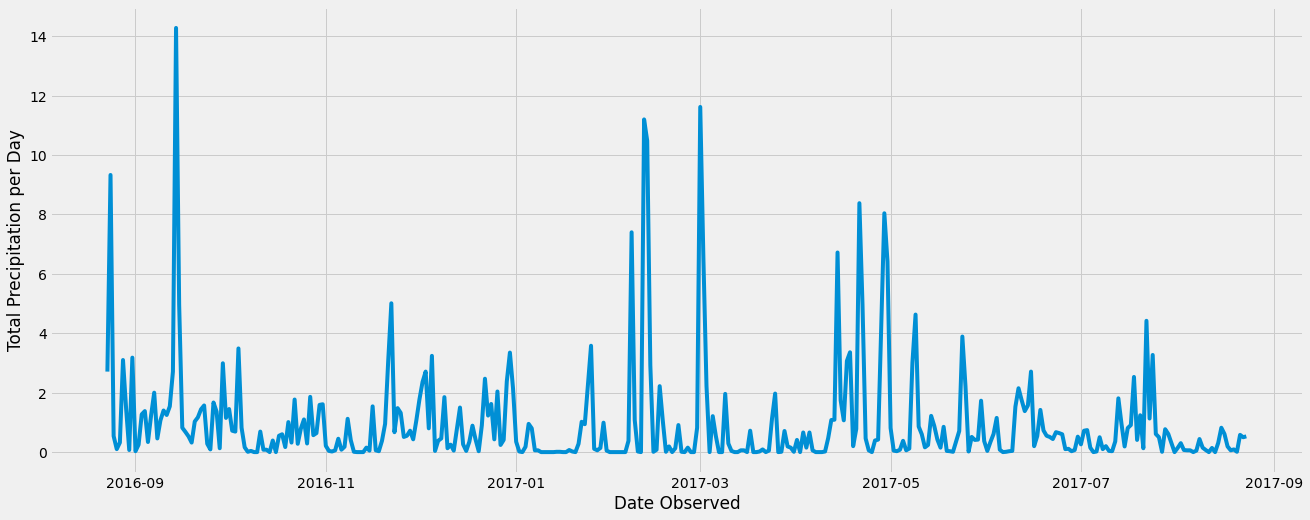

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

date_list = precip_sum_df_no_index['date']
date_list
precip_list = precip_sum_df_no_index['prcp']
precip_list

plt.figure(figsize=(20,8))
plt.plot(date_list, precip_list)
#plt.locator_params(axis='x', tight=True, nbins=13)
plt.xlabel("Date Observed")
plt.ylabel("Total Precipitation per Day")


#plt.xticks(rotation='vertical')
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
stations_count = engine.execute("SELECT COUNT (DISTINCT(station)) FROM station").fetchall()[0][0]
print(f"Total number of stations: {stations_count}")

Total number of stations: 9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = engine.execute("SELECT station, COUNT(station) \
                             FROM measurement \
                             GROUP BY station\
                             ORDER BY COUNT(station) DESC\
                             ").fetchall()
for station in most_active:
    print(station)
most_active_id = most_active[0][0]
most_active_id

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


'USC00519281'

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest  = engine.execute(f"SELECT MIN(tobs) FROM measurement WHERE station = '{most_active_id}'").fetchall()[0][0]
highest = engine.execute(f"SELECT MAX(tobs) FROM measurement WHERE station = '{most_active_id}'").fetchall()[0][0]
average = engine.execute(f"SELECT AVG(tobs) FROM measurement WHERE station = '{most_active_id}'").fetchall()[0][0]
print(f"At station ID#: {most_active_id}:")
print(f"Low temp:  {lowest} °F")
print(f"High temp: {highest} °F")
print(f"Avg temp:  {round(average,1)} °F")

At station ID#: USC00519281:
Low temp:  54.0 °F
High temp: 85.0 °F
Avg temp:  71.7 °F


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# last_12_df = pd.DataFrame(engine.execute(f"SELECT date, tobs FROM measurement \
#     WHERE station = '{most_active_id}'").fetchall(), columns = ['Date','Temp °F'])

last_12_df = pd.DataFrame(
    session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_id).\
    filter(Measurement.date < str(newest_date)).filter(Measurement.date > str(one_year_previous)).all(),\
    columns = ['Date', 'Temp °F']\
)
    
last_12_df['Date'] = pd.to_datetime(last_12_df['Date'])
last_12_df

,Date,Temp °F
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


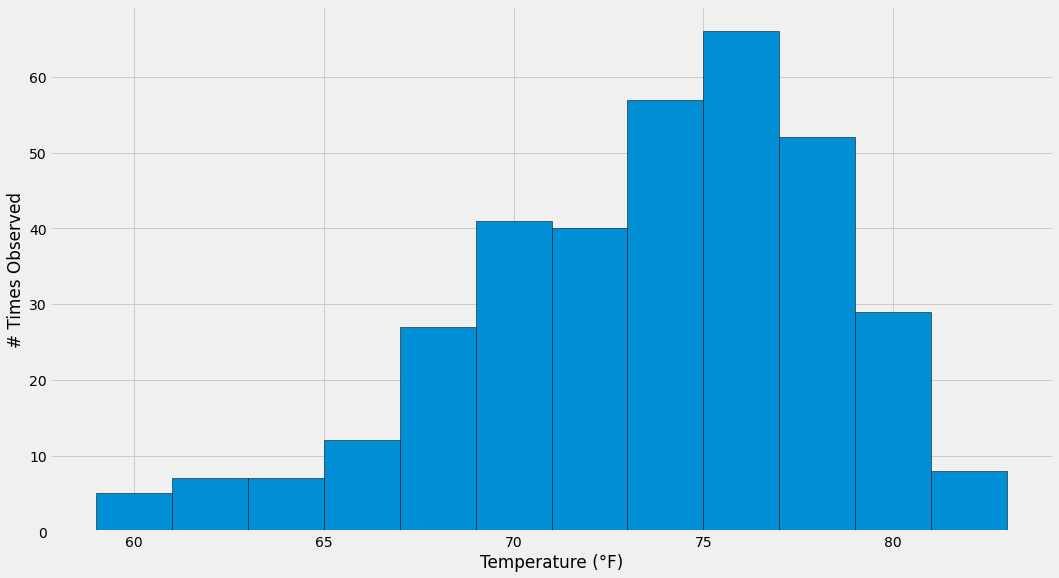

In [28]:
#plt.hist(last_12_df['Date'], bins=12)
# Initialize layout
fig, ax = plt.subplots(figsize = (16, 9))

#plot
ax.hist(last_12_df['Temp °F'], bins=12, edgecolor="black")
plt.xlabel('Temperature (°F)')
plt.ylabel('# Times Observed')
plt.show()

# Close session

In [22]:
# Close Session
session.close()